**Prática 4 – Aplicação e Combinação de Classificadores Avançados**

**Alunos:

GIOVANNI SURIANI FERREIRA

JORGE ALIOMAR TROCOLI ABDON DANTAS**

**Objetivo(s):**

Nesta atividade prática, você irá aplicar três dos classificadores mais avançados em Aprendizado de Máquina para dados
tabulares: XGBoost, LightGBM e CatBoost. Em seguida, irá combiná-los utilizando duas estratégias de ensemble:
VotingClassifier e StackingClassifier. O desempenho dos modelos será avaliado por meio de validação cruzada
estratificada com 10 folds e por submissão dos resultados ao leaderboard do Kaggle.

# DESAFIO E PROBLEMA ESCOLHIDO
Home Credit Default Risk (https://www.kaggle.com/competitions/home-credit-default-risk)

O desafio consiste em melhorar os modelos preditivos, da HOME CREDIT, de crédito voltados a pessoas sem histórico bancário. Utilizando dados alternativos como registros de telecomunicações e transações, a empresa quer garantir que mais pessoas aptas recebam empréstimos justos e sustentáveis. O desafio propõe que os participantes usem técnicas de ciência de dados e machine learning para prever com mais precisão a capacidade de pagamento dos clientes.

O conjunto de dados contém informações detalhadas sobre o histórico financeiro de clientes da Home Credit e de outras instituições, com o objetivo de prever a capacidade de pagamento de novos empréstimos.

 - application_{train|test}.csv: Esta é a tabela principal, dividida em dois arquivos: Treinamento (com a variável TARGET) e Teste (sem TARGET). Contém dados estáticos de todas as solicitações de empréstimo. Cada linha representa um empréstimo.

 - bureau.csv: Todos os créditos anteriores dos clientes fornecidos por outras instituições financeiras, reportados ao Bureau de Crédito (apenas para clientes com empréstimo na amostra). Cada linha representa um crédito anterior registrado antes da data da aplicação atual.
 
 - bureau_balance.csv: Saldos mensais dos créditos anteriores no Bureau de Crédito. Cada linha representa um mês de histórico para cada crédito anterior — ou seja, número de empréstimos * número de créditos anteriores * número de meses com histórico disponível.

 - POS_CASH_balance.csv: Saldos mensais dos empréstimos anteriores no ponto de venda (POS) ou empréstimos em dinheiro que o cliente teve com a Home Credit. Uma linha por mês de histórico de cada crédito anterior relacionado ao empréstimo na amostra.

 - credit_card_balance.csv: Saldos mensais dos cartões de crédito anteriores que o cliente tem com a Home Credit. Formato similar ao POS_CASH_balance, mas para cartões de crédito.

 - previous_application.csv: Todas as solicitações anteriores de empréstimos feitas à Home Credit por clientes com empréstimos na amostra atual. Uma linha por solicitação anterior.

 - installments_payments.csv: Histórico de pagamentos de créditos anteriores concedidos pela Home Credit. Inclui: a) uma linha para cada pagamento feito, e b) uma linha para cada parcela não paga. Cada linha representa um pagamento ou uma parcela de um crédito anterior.

 - HomeCredit_columns_description.csv: Arquivo com a descrição das colunas de todos os outros arquivos do conjunto de dados.

 As tabelas podem se relacionar conforme imagem abaixo:

 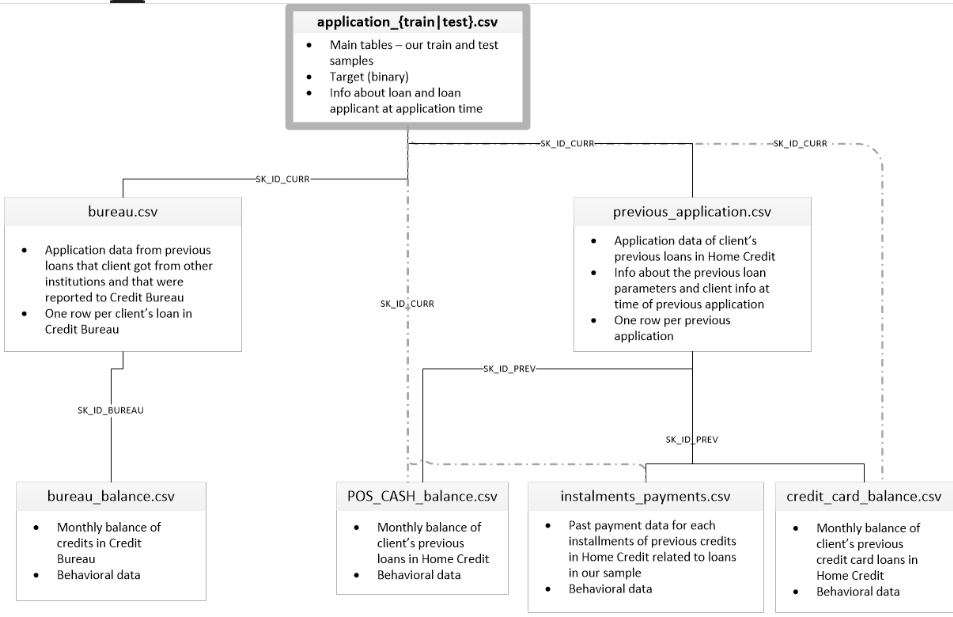




# PREPARAÇÃO DA BASE DE DADOS - Todos os dados

In [ ]:
#Importando Bibliotecas Pandas e Numpy
import pandas as pd
import numpy as np
import os, sys

#Importando BiBliotecas DASK  (alternativa ao Pandas)
import dask.dataframe as dd

#Otimizador Giovanni
from sklearnex import patch_sklearn 
patch_sklearn()


CSV_PATH = "/home/gi/Desktop/Semestre8/Inteligencia_Computacional/TP1_csvs" # Path Giovanni
#CSV_PATH = f" E:/Documentos/CEFET/OneDrive/Documentos/2ECOM067_INTELIGENCIA-COMPUTACIONAL-I_T01/TP1/bases/ # Path Jorge

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [6]:
import warnings
warnings.simplefilter("ignore")

In [7]:
#Carregando Base de dados principal
df_test  = pd.read_csv(f"{CSV_PATH}/application_test.csv")
df_train = pd.read_csv(f"{CSV_PATH}/application_train.csv")

In [8]:
# Como o volume de informações é muito grande, iremos ao invés de montar uma base única entre a base principal e as 
# demais tabelas auxiliares, iremos criar 4 bases (conforme descrito abaixo), realizar as devidas simulações e utilizar 
# as estratégias de emsemble VotingClassifier e StackingClassifier.
# Bases que serão construídas:
#   -   df_01 = application_train + bureau + bureau_balance
#   -   df_02 = application_train + previous_application + POS_CASH_balance
#   -   df_03 = application_train + previous_application + installments_payments
#   -   df_04 = application_train + previous_application + credit_card_balance

## DataFrame 01 = application_train + bureau + bureau_balance

In [9]:
#Carregamento de Bases de Dados Auxiliares
df_auxiliar_bureau                          = pd.read_csv(f"{CSV_PATH}/bureau.csv")
df_auxiliar_bureau_balance                  = pd.read_csv(f"{CSV_PATH}/bureau_balance.csv")

In [10]:
#Copia do df_train
df_01 = df_train.copy()

In [11]:
#Realização do left join de df_train com df_auxiliar_bureau
# DF da esquerda = df_train
# DF da direita  = df_auxiliar_bureau
df_01 = df_01.join(df_auxiliar_bureau, on='SK_ID_CURR', lsuffix = ' ', how='left')
df_01 = df_01.drop(columns={"SK_ID_CURR"}) #Excluir coluna duplicada

#Realização do left join de df_01 com df_auxiliar_bureau_balance
# DF da esquerda = df_01
# DF da direita  = df_auxiliar_bureau_balance
df_01 = df_01.join(df_auxiliar_bureau_balance, on='SK_ID_BUREAU', lsuffix = ' ',  how='left')
df_01 = df_01.drop(columns={"SK_ID_BUREAU"}) #Excluir coluna duplicada

## DataFrame 02 = application_train + previous_application + POS_CASH_balance

In [12]:
#Carregamento de Bases de Dados Auxiliares
df_auxiliar_previous_application            = pd.read_csv(f"{CSV_PATH}/previous_application.csv")
df_auxiliar_POS_CASH_balance                = pd.read_csv(f"{CSV_PATH}/POS_CASH_balance.csv")

In [13]:
#Copia do df_train
df_02 = df_train.copy()

In [14]:
#Realização do left join de df_train com df_auxiliar_previous_application
# DF da esquerda = df_train
# DF da direita  = df_auxiliar_previous_application
df_02 = df_02.join(df_auxiliar_previous_application, on='SK_ID_CURR', lsuffix = ' ', how='left')
df_02 = df_02.drop(columns={"SK_ID_CURR"}) #Excluir coluna duplicada

#Realização do left join de df_02 com df_auxiliar_POS_CASH_balance
# DF da esquerda = df_02
# DF da direita  = df_auxiliar_POS_CASH_balance
df_02 = df_02.join(df_auxiliar_POS_CASH_balance, on='SK_ID_PREV', lsuffix = ' ',  how='left')
df_02 = df_02.drop(columns={"SK_ID_PREV"}) #Excluir coluna duplicada

## DataFrame 03 = application_train + previous_application + installments_payments

In [15]:
#Carregamento de Bases de Dados Auxiliares
#df_auxiliar_previous_application            = pd.read_csv(f"{CSV_PATH}/previous_application.csv")
df_auxiliar_installments_payments           = pd.read_csv(f"{CSV_PATH}/installments_payments.csv")

In [16]:
#Copia do df_train
df_03 = df_train.copy()

In [17]:
#Realização do left join de df_train com df_auxiliar_previous_application
# DF da esquerda = df_train
# DF da direita  = df_auxiliar_previous_application
df_03 = df_03.join(df_auxiliar_previous_application, on='SK_ID_CURR', lsuffix = ' ', how='left')
df_03 = df_03.drop(columns={"SK_ID_CURR"}) #Excluir coluna duplicada

#Realização do left join de df_03 com df_auxiliar_installments_payments
# DF da esquerda = df_03
# DF da direita  = df_auxiliar_installments_payments
df_03 = df_03.join(df_auxiliar_installments_payments, on='SK_ID_PREV', lsuffix = ' ',  how='left')
df_03 = df_03.drop(columns={"SK_ID_PREV"}) #Excluir coluna duplicada

## DataFrame 04 = application_train + previous_application + credit_card_balance

In [18]:
#Carregamento de Bases de Dados Auxiliares
#df_auxiliar_previous_application            = pd.read_csv(f"{CSV_PATH}/previous_application.csv")
df_auxiliar_credit_card_balances            = pd.read_csv(f"{CSV_PATH}/credit_card_balance.csv")

In [19]:
#Copia do df_train
df_04 = df_train.copy()

In [20]:
#Realização do left join de df_train com df_auxiliar_previous_application
# DF da esquerda = df_train
# DF da direita  = df_auxiliar_previous_application
df_04 = df_04.join(df_auxiliar_previous_application, on='SK_ID_CURR', lsuffix = ' ', how='left')
df_04 = df_04.drop(columns={"SK_ID_CURR"}) #Excluir coluna duplicada

#Realização do left join de df_03 com df_auxiliar_credit_card_balances
# DF da esquerda = df_04
# DF da direita  = df_auxiliar_credit_card_balances
df_04 = df_04.join(df_auxiliar_credit_card_balances, on='SK_ID_PREV', lsuffix = ' ',  how='left')
df_04 = df_04.drop(columns={"SK_ID_PREV"}) #Excluir coluna duplicada

In [21]:
# Tamanhos dos Data Frames criados
print(df_01.shape, df_02.shape, df_03.shape, df_04.shape)

(307511, 140) (307511, 165) (307511, 165) (307511, 180)


# PREPARAÇÃO DA BASE DE DADOS - Amostra

Como as bases de dados original tem muitos valores, e as simulações subsequentes podem demorar muitas horas, realizar-se-a uma amostra aleatória das bases para treinamento e teste 


In [22]:
#Amostra df_01
df_01_amostrado = df_01.sample(frac=0.2, random_state=42)  # Seleciona 20% do DataFrame


#Removendo colunas duplicadas
lista_colunas_duplicadas = [137]
df_01_amostrado.drop(df_01_amostrado.columns[lista_colunas_duplicadas], axis=1, inplace = True)

#Divisão treino e teste
X_train_df_01_amostrado =  df_01_amostrado.drop(columns={"TARGET"})
y_train_df_01_amostrado =  df_01_amostrado.TARGET

In [23]:
#Amostra df_02
df_02_amostrado = df_02.sample(frac=0.2, random_state=42)  # Seleciona 20% do DataFrame


#Removendo colunas duplicadas
lista_colunas_duplicadas = [129, 158, 141, 123, 162, 130, 128, 126, 124]
df_02_amostrado.drop(df_02_amostrado.columns[lista_colunas_duplicadas], axis=1, inplace = True)

# Limpar nomes das colunas (remover caracteres especiais inválidos para JSON)
import re
df_02_amostrado.columns = [re.sub(r'[^\w]', '', col) for col in df_02_amostrado.columns]

#Divisão treino e teste
X_train_df_02_amostrado =  df_02_amostrado.drop(columns={"TARGET"})
y_train_df_02_amostrado =  df_02_amostrado.TARGET

In [24]:
#Amostra df_03
df_03_amostrado = df_03.sample(frac=0.2, random_state=42)  # Seleciona 20% do DataFrame

#Removendo colunas duplicadas
lista_colunas_duplicadas = [158, 123, 124, 126, 128, 129, 130, 141]
df_03_amostrado.drop(df_03_amostrado.columns[lista_colunas_duplicadas], axis=1, inplace = True)

# Limpar nomes das colunas (remover caracteres especiais inválidos para JSON)
import re
df_03_amostrado.columns = [re.sub(r'[^\w]', '', col) for col in df_03_amostrado.columns]

#Divisão treino e teste
X_train_df_03_amostrado =  df_03_amostrado.drop(columns={"TARGET"})
y_train_df_03_amostrado =  df_03_amostrado.TARGET

In [25]:
#Amostra df_04
df_04_amostrado = df_04.sample(frac=0.2, random_state=42)


#Removendo colunas duplicadas
lista_colunas_duplicadas = [158, 123, 124, 126, 128, 129, 130, 141, 177]
df_04_amostrado.drop(df_04_amostrado.columns[lista_colunas_duplicadas], axis=1, inplace = True)

# Limpar nomes das colunas (remover caracteres especiais inválidos para JSON)
import re
df_04_amostrado.columns = [re.sub(r'[^\w]', '', col) for col in df_04_amostrado.columns]


#Divisão treino e teste
X_train_df_04_amostrado =  df_04_amostrado.drop(columns={"TARGET"})
y_train_df_04_amostrado =  df_04_amostrado.TARGET

# 1. Treinamento Individual dos Classificadores

In [26]:
#Importanto as Bibliotecas dos classificadores
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [27]:
#Lista dos Modelos por Classificador
modelos =   [('XGBOOST  - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6', XGBClassifier(random_state=42, learning_rate = 0.3, max_depth = 6)), 
             #('XGBOOST  - Config.02 - random_state=42, learning_rate = 0.3, max_depth = 8', XGBClassifier(random_state=42, learning_rate = 0.3, max_depth = 8)), 
             #('XGBOOST  - Config.03 - random_state=42, learning_rate = 0.2, max_depth = 6', XGBClassifier(random_state=42, learning_rate = 0.2, max_depth = 6)), 
             #('XGBOOST  - Config.04 - random_state=42, learning_rate = 0.2, max_depth = 8', XGBClassifier(random_state=42, learning_rate = 0.2, max_depth = 8)), 
             ('LIGHTGBM - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6', LGBMClassifier(random_state=42, learning_rate = 0.3, max_depth = 6, force_col_wise=True)), 
             #('LIGHTGBM - Config.02 - random_state=42, learning_rate = 0.3, max_depth = 8', LGBMClassifier(random_state=42, learning_rate = 0.3, max_depth = 8, force_col_wise=True)), 
             #('LIGHTGBM - Config.03 - random_state=42, learning_rate = 0.2, max_depth = 6', LGBMClassifier(random_state=42, learning_rate = 0.2, max_depth = 6, force_col_wise=True)), 
             #('LIGHTGBM - Config.04 - random_state=42, learning_rate = 0.2, max_depth = 8', LGBMClassifier(random_state=42, learning_rate = 0.2, max_depth = 8, force_col_wise=True)), 
             ('CATBOOST - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6', CatBoostClassifier(random_state=42, learning_rate = 0.3, max_depth = 6)), 
             #('CATBOOST - Config.02 - random_state=42, learning_rate = 0.3, max_depth = 8', CatBoostClassifier(random_state=42, learning_rate = 0.3, max_depth = 8)), 
             #('CATBOOST - Config.03 - random_state=42, learning_rate = 0.2, max_depth = 6', CatBoostClassifier(random_state=42, learning_rate = 0.2, max_depth = 6)), 
             #('CATBOOST - Config.04 - random_state=42, learning_rate = 0.2, max_depth = 8', CatBoostClassifier(random_state=42, learning_rate = 0.2, max_depth = 8)),     
            ]

In [28]:
#Transformando as variáveis catégóricas em binárias via get.dummies do df_01

#Seleção dos atributos categóricos do df_01
atributos_categoricos = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                         'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                         'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
                         'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
                         'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
                         'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'STATUS'
]

# Transformar usando pd.get_dummies
X_train_df_01_amostrado_dummificado = pd.get_dummies(X_train_df_01_amostrado, columns=atributos_categoricos, drop_first=True)


# Limpar nomes das colunas (remover caracteres especiais inválidos para JSON)
import re
X_train_df_01_amostrado_dummificado.columns = [re.sub(r'[^\w]', '', col) for col in X_train_df_01_amostrado_dummificado.columns]

In [29]:
#Treino df_01
from sklearn.model_selection import cross_validate

Resultados_df_01=[]
for nome, classifier in modelos:
  scores = cross_validate(classifier, X_train_df_01_amostrado_dummificado, y_train_df_01_amostrado, scoring=['roc_auc'], cv = 10)
  scores_roc_auc  = scores["test_roc_auc"].mean()
  Resultados_df_01.append({'Modelo': nome,
                    'roc_auc': scores_roc_auc})

[LightGBM] [Info] Number of positive: 4454, number of negative: 50897
[LightGBM] [Info] Total Bins 13688
[LightGBM] [Info] Number of data points in the train set: 55351, number of used features: 240
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436001
[LightGBM] [Info] Start training from score -2.436001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [30]:
#Impressão dos Resultados df_01
print(f'Modelo \t\t\t\t\t\t\t\t\t\t\t ROC_UAC')
for r in Resultados_df_01:
    print(f'{r["Modelo"]:<90}{r["roc_auc"]:.4f}')

Modelo 											 ROC_UAC
XGBOOST  - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.7180
LIGHTGBM - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.7170
CATBOOST - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.6931


In [31]:
#Transformando as variáveis catégóricas em binárias via get.dummies do df_02

#Seleção dos atributos categóricos do df_02
atributos_categoricos = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                         'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                         'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
                         'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
                         'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS',
                         'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
                         'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY',
                         'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION'
                        ]

# Transformar usando pd.get_dummies
X_train_df_02_amostrado_dummificado = pd.get_dummies(X_train_df_02_amostrado, columns=atributos_categoricos, drop_first=True)


# Limpar nomes das colunas (remover caracteres especiais inválidos para JSON)
import re
X_train_df_02_amostrado_dummificado.columns = [re.sub(r'[^\w]', '', col) for col in X_train_df_02_amostrado_dummificado.columns]

In [32]:
#Treino df_02
from sklearn.model_selection import cross_validate

Resultados_df_02=[]
for nome, classifier in modelos:
  scores = cross_validate(classifier, X_train_df_02_amostrado_dummificado, y_train_df_02_amostrado, scoring=['roc_auc'], cv = 10)
  scores_roc_auc  = scores["test_roc_auc"].mean()
  Resultados_df_02.append({'Modelo': nome,
                    'roc_auc': scores_roc_auc})

[LightGBM] [Info] Number of positive: 4454, number of negative: 50897
[LightGBM] [Info] Total Bins 14183
[LightGBM] [Info] Number of data points in the train set: 55351, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436001
[LightGBM] [Info] Start training from score -2.436001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [33]:
#Impressão dos Resultados df_02
print(f'Modelo \t\t\t\t\t\t\t\t\t\t\t ROC_UAC')
for r in Resultados_df_02:
    print(f'{r["Modelo"]:<90}{r["roc_auc"]:.4f}')

Modelo 											 ROC_UAC
XGBOOST  - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.7151
LIGHTGBM - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.7149
CATBOOST - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.6918


In [34]:
#Transformando as variáveis categóricas em binárias via get.dummies do df_03

#Seleção dos atributos categóricos do df_03
atributos_categoricos = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_TYPE_SUITE",
                        "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE",
                        "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE", "FONDKAPREMONT_MODE", 
                        "HOUSETYPE_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE", "FLAG_LAST_APPL_PER_CONTRACT", 
                        "NAME_CASH_LOAN_PURPOSE", "NAME_CONTRACT_STATUS", "NAME_PAYMENT_TYPE", "CODE_REJECT_REASON", 
                        "NAME_CLIENT_TYPE", "NAME_GOODS_CATEGORY", "NAME_PORTFOLIO", "NAME_PRODUCT_TYPE", "CHANNEL_TYPE",
                        "NAME_SELLER_INDUSTRY","NAME_YIELD_GROUP", "PRODUCT_COMBINATION"]

# Transformar usando pd.get_dummies
X_train_df_03_amostrado_dummificado = pd.get_dummies(X_train_df_03_amostrado, columns=atributos_categoricos, drop_first=True)


# Limpar nomes das colunas (remover caracteres especiais inválidos para JSON)
import re
X_train_df_03_amostrado_dummificado.columns = [re.sub(r'[^\w]', '', col) for col in X_train_df_03_amostrado_dummificado.columns]

In [35]:
#Treino df_03
from sklearn.model_selection import cross_validate

Resultados_df_03=[]
for nome, classifier in modelos:
  scores = cross_validate(classifier, X_train_df_03_amostrado_dummificado, y_train_df_03_amostrado, scoring=['roc_auc'], cv = 10)
  scores_roc_auc  = scores["test_roc_auc"].mean()
  Resultados_df_03.append({'Modelo': nome,
                    'roc_auc': scores_roc_auc})

[LightGBM] [Info] Number of positive: 4454, number of negative: 50897
[LightGBM] [Info] Total Bins 15115
[LightGBM] [Info] Number of data points in the train set: 55351, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436001
[LightGBM] [Info] Start training from score -2.436001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [36]:
#Impressão dos Resultados df_03
print(f'Modelo \t\t\t\t\t\t\t\t\t\t\t ROC_UAC')
for r in Resultados_df_03:
    print(f'{r["Modelo"]:<90}{r["roc_auc"]:.4f}')

Modelo 											 ROC_UAC
XGBOOST  - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.7173
LIGHTGBM - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.7178
CATBOOST - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.6968


In [37]:
#Transformando as variáveis categóricas em binárias via get.dummies do df_04

#Seleção dos atributos categóricos do df_04
atributos_categoricos = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
                         "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE",
                         "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "OCCUPATION_TYPE",
                         "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE", "FONDKAPREMONT_MODE",
                         "HOUSETYPE_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE",
                         "FLAG_LAST_APPL_PER_CONTRACT", "NAME_CASH_LOAN_PURPOSE",
                         "NAME_CONTRACT_STATUS", "NAME_PAYMENT_TYPE", "CODE_REJECT_REASON",
                         "NAME_CLIENT_TYPE", "NAME_GOODS_CATEGORY", "NAME_PORTFOLIO",
                         "NAME_PRODUCT_TYPE", "CHANNEL_TYPE", "NAME_SELLER_INDUSTRY",
                         "NAME_YIELD_GROUP", "PRODUCT_COMBINATION"
                        ]

# Transformar usando pd.get_dummies
X_train_df_04_amostrado_dummificado = pd.get_dummies(X_train_df_04_amostrado, columns=atributos_categoricos, drop_first=True)


# Limpar nomes das colunas (remover caracteres especiais inválidos para JSON)
import re
X_train_df_04_amostrado_dummificado.columns = [re.sub(r'[^\w]', '', col) for col in X_train_df_04_amostrado_dummificado.columns]

In [38]:
#Treino df_04
from sklearn.model_selection import cross_validate

Resultados_df_04=[]
for nome, classifier in modelos:
  scores = cross_validate(classifier, X_train_df_04_amostrado_dummificado, y_train_df_04_amostrado, scoring=['roc_auc'], cv = 10)
  scores_roc_auc  = scores["test_roc_auc"].mean()
  Resultados_df_04.append({'Modelo': nome,
                    'roc_auc': scores_roc_auc})

[LightGBM] [Info] Number of positive: 4454, number of negative: 50897
[LightGBM] [Info] Total Bins 17037
[LightGBM] [Info] Number of data points in the train set: 55351, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436001
[LightGBM] [Info] Start training from score -2.436001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [39]:
#Impressão dos Resultados df_04
print(f'Modelo \t\t\t\t\t\t\t\t\t\t\t ROC_UAC')
for r in Resultados_df_04:
    print(f'{r["Modelo"]:<90}{r["roc_auc"]:.4f}')

Modelo 											 ROC_UAC
XGBOOST  - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.7151
LIGHTGBM - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.7143
CATBOOST - Config.01 - random_state=42, learning_rate = 0.3, max_depth = 6                0.6958


# 2. Combinação com VotingClassifier (Hard e Soft)

Pegou-se os modelos com melhores resultados dos dataframes df_01, df_02, df_03 e df_04 e aplicou-se a estratégia do VotingClassifier

In [40]:
#Importando Bibliotecas pertinentes
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [41]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [42]:
def avaliar_modelo(modelo, X, y, nome="Modelo"):
    roc_auc = []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        modelo.fit(X_train, y_train)
        preds = modelo.predict(X_test)
        roc_auc.append(roc_auc_score(y_test, preds))
    print(f"{nome}: roc_auc = {np.mean(roc_auc):.4f}, desvio padrão = {np.std(roc_auc):.4f}")

In [43]:
estimador_df_01 = XGBClassifier(random_state=42, learning_rate = 0.3, max_depth = 6)
estimador_df_02 = LGBMClassifier(random_state=42, learning_rate = 0.3, max_depth = 6, force_col_wise=True)
estimador_df_03 = LGBMClassifier(random_state=42, learning_rate = 0.3, max_depth = 6, force_col_wise=True)
estimador_df_04 = CatBoostClassifier(random_state=42, learning_rate = 0.3, max_depth = 6)


voting_hard = VotingClassifier(estimators=[('df_01', estimador_df_01), ('df_02', estimador_df_02), 
                                           ('df_03', estimador_df_03), ('df_04', estimador_df_04)], voting='hard')
voting_soft = VotingClassifier(estimators=[('df_01', estimador_df_01), ('df_02', estimador_df_02), 
                                           ('df_03', estimador_df_03), ('df_04', estimador_df_04)], voting='soft')

X = X_train_df_01_amostrado_dummificado.copy()
y = y_train_df_01_amostrado.copy()

avaliar_modelo(voting_hard, X, y, "VotingClassifier (Hard)")
avaliar_modelo(voting_soft, X, y, "VotingClassifier (Soft)")

[LightGBM] [Info] Number of positive: 4454, number of negative: 50897
[LightGBM] [Info] Total Bins 13693
[LightGBM] [Info] Number of data points in the train set: 55351, number of used features: 239
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436001
[LightGBM] [Info] Start training from score -2.436001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

# 3. Combinação com StackingClassifier

In [45]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimador_df_01 = XGBClassifier(random_state=42, learning_rate = 0.3, max_depth = 6)
estimador_df_02 = LGBMClassifier(random_state=42, learning_rate = 0.3, max_depth = 6, force_col_wise=True)
estimador_df_03 = LGBMClassifier(random_state=42, learning_rate = 0.3, max_depth = 6, force_col_wise=True)
estimador_df_04 = CatBoostClassifier(random_state=42, learning_rate = 0.3, max_depth = 6)

stacking = StackingClassifier(estimators=[('df_01', estimador_df_01), ('df_02', estimador_df_02), 
                                           ('df_03', estimador_df_03), ('df_04', estimador_df_04)], 
                                           final_estimator=LogisticRegression(), cv=5)
avaliar_modelo(stacking, X, y, "StackingClassifier")

[LightGBM] [Info] Number of positive: 4454, number of negative: 50897
[LightGBM] [Info] Total Bins 13693
[LightGBM] [Info] Number of data points in the train set: 55351, number of used features: 239
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436001
[LightGBM] [Info] Start training from score -2.436001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

# Dataframes para o Kaggle

In [ ]:
X_test = df_test.copy()
X_train_encoded = pd.get_dummies(X) # Transformar variáveis categóricas em binárias
X_test_encoded = pd.get_dummies(X_test) # Transformar variáveis categóricas em binárias

# Alinhe as colunas entre treino e teste
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


In [50]:
#Predição do Modelo com os dados de Teste Global
predictions_voting      = voting_hard.predict(X_test_encoded) ## Escolher o melhor do Voting
predictions_stacking    = stacking.predict(X_test_encoded) ## Escolher o melhor do Voting

In [52]:
#Geração do Data Frame das predições com o Teste Global 
df_test_voting = df_test.copy()
df_test_voting["TARGET"] = predictions_voting

df_test_stacking = df_test.copy()
df_test_stacking["TARGET"] = predictions_stacking

# Salvar os CSVs
df_test_voting[["SK_ID_CURR", "TARGET"]].to_csv("voting.csv", index=False)
df_test_stacking[["SK_ID_CURR", "TARGET"]].to_csv("stacking.csv", index=False)


In [53]:
#Exibição do Data Frame que será enviado para o Kaggle
df_test_voting[["SK_ID_CURR","TARGET"]]
df_test_stacking[["SK_ID_CURR","TARGET"]]

SK_ID_CURR  TARGET
0          100001       0
1          100005       0
2          100013       0
3          100028       0
4          100038       0
...           ...     ...
48739      456221       0
48740      456222       0
48741      456223       0
48742      456224       0
48743      456250       0

[48744 rows x 2 columns]

#RESULTADOS

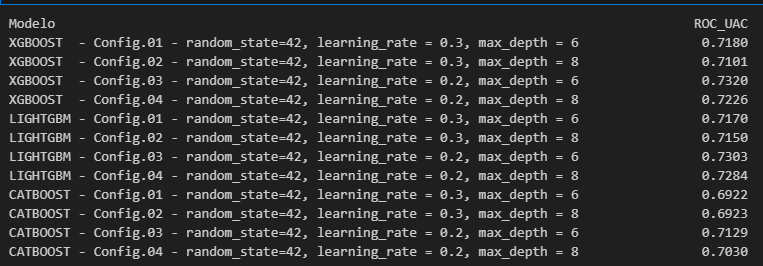